## НИУ ВШЭ НН. Факультет ИМиКН. Методы анализа данных. Charge de cours: В. А. Калягин
#### **Домашнее задание 1:** данные, пропуски, выбросы, методы снижения размерности (PCA, MDS). **Вариант 14**. Выполнил: **Игорь Рухович**

### Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

### Код для чтения данных + общие переменные

In [2]:
data_path = "../data/xls/"
filename = lambda number: f"22MAG_HW_1_v{number}.xls"
variants = range(1, 16)
my_variant = 14
random_state = 123
columns = [
    "Age (years)",
    "Family size",
    "Monthly income (RUB)",
    "Residence in the region (years)",
    "Car valuation (USD)",
    "Loan amount (x1000 RUB)",
]
dtypes = [
    int,
    int,
    float,
    float,
    float,
    int,
]
types_dict = {elem[0]: elem[1] for elem in zip(columns, dtypes)}

def read_specific_variant(number: int) -> pd.DataFrame:
    return pd.read_excel(data_path + filename(number), header=None, names=columns)

def read_all_variants(hue: int = None) -> pd.DataFrame:
    dfs = []
    for var in variants:
        new_df = read_specific_variant(var)
        if hue is not None:
            val = "14th variant" if hue == var else "others"
            new_df["data_from"] = val
        dfs.append(new_df)
        result = pd.concat(dfs, ignore_index=True)
    return result

## Данные. Первичная обработка.
### **1. Рассмотрим данные**
Для большей полноты картины для работы были взяты данные из всех 15 вариантов.  
Для чистоты эксперимента, на всех графиках и преобразованиях будем отдельно помечать мой вариант (№14).  
Создадим дополнительную колонку `data_from`, в которой разделим `14th variant` и `others`.  
Рассмотрим первые строчки полных данных:

In [3]:
df = read_all_variants(my_variant)
df14 = read_specific_variant(my_variant)
df.head()

,Age (years),Family size,Monthly income (RUB),Residence in the region (years),Car valuation (USD),Loan amount (x1000 RUB),data_from
0,38.0,2.0,22600.0,8.0,22000.0,NaN,others
1,47.0,2.0,11200.0,14.0,12000.0,119000.0,others
2,NaN,2.0,22500.0,9.0,22000.0,224000.0,others
3,51.0,3.0,16000.0,17.0,18000.0,173000.0,others
4,41.0,2.0,NaN,11.0,6000.0,57000.0,others


Соберём некоторые статистики: среднее, стандартное отклонение и каждый 25-й процентиль:

In [4]:
df.describe()

,Age (years),Family size,Monthly income (RUB),Residence in the region (years),Car valuation (USD),Loan amount (x1000 RUB)
count,699.000000,703.000000,702.000000,706.000000,702.000000,705.000000
mean,39.110157,2.021337,19445.299145,10.172805,21173.789174,201406.099291
std,8.784145,1.013217,9877.044344,4.828538,11278.272303,97600.870198
min,19.000000,0.000000,700.000000,0.000000,0.000000,3000.000000
25%,33.000000,1.000000,11300.000000,6.000000,13000.000000,127000.000000
50%,39.000000,2.000000,19550.000000,10.000000,20000.000000,200000.000000
75%,45.000000,3.000000,27850.000000,13.750000,29000.000000,274000.000000
max,60.000000,5.000000,43300.000000,22.000000,50000.000000,437000.000000


Дополнительно построим гистограммы распределения и диаграммы размаха для каждого признака, чтобы лучше понять их структуру и распределение.  
**Синим** цветом построим графики **для полных данных**, **оранжевым** - для **варианта 14**.

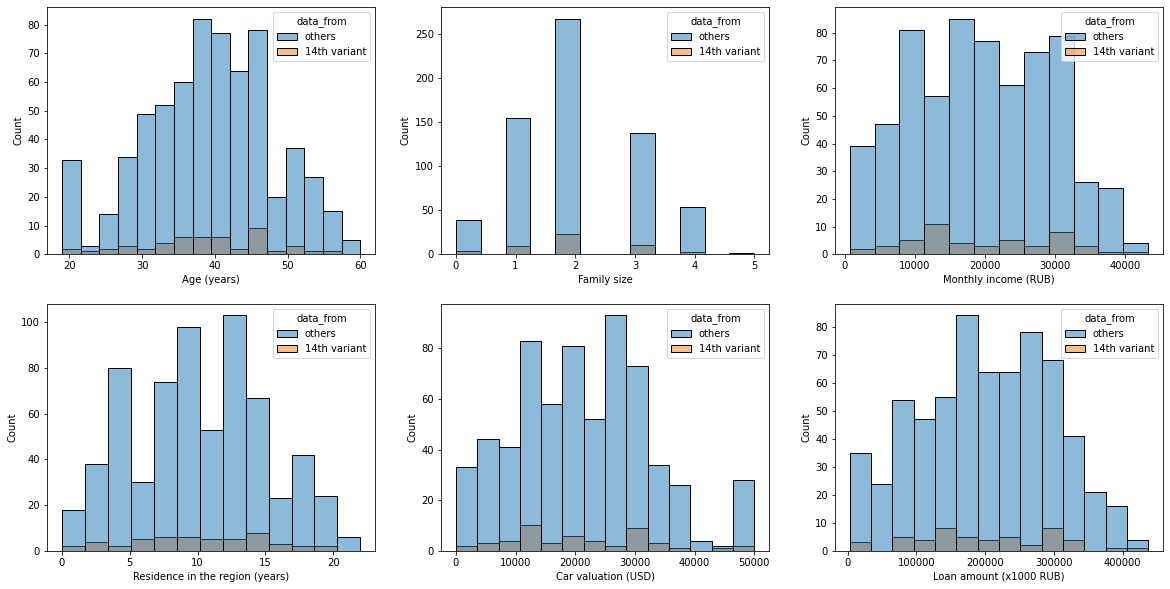

In [5]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20,10)

for i in range(6):
    sns.histplot(data=df, x=columns[i], ax=np.ravel(axs)[i], hue="data_from")

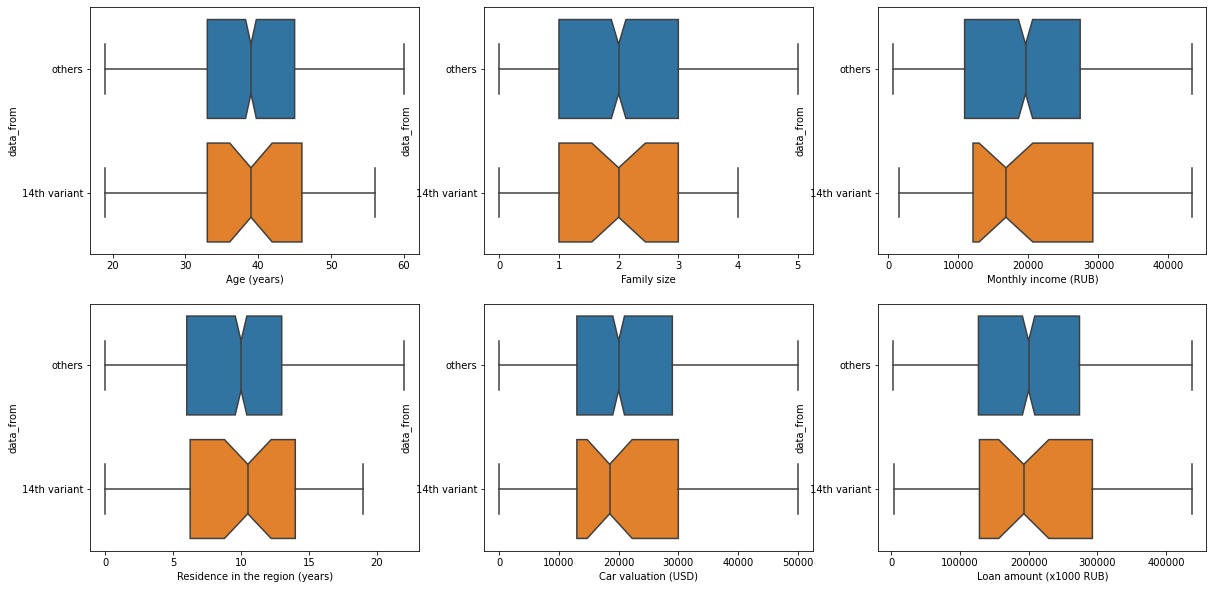

In [6]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20,10)

for i in range(6):
    sns.boxplot(data=df, x=columns[i], ax=np.ravel(axs)[i], notch=True, y="data_from", whis=1.5)

Отметим, что визуально гистограммы распределения всех признаков **напоминают нормальное с некоторыми отклонениями**.  
Диаграммы размаха говорят нам о том, что **бОльшая часть** данных по всем признакам **сосредоточена вокруг медианы**,  
причём **чем больше данных** берётся для рассмотрения, **тем ближе к центру** они группируются  
**(синие участки "уже" оранжевых, тогда как "усы" у синих шире)**

Отдельно заметим, что все данные лежат на расстоянии  $\leq 1.5$ ширины "ящика" (`whis=1.5`), поскольку ни один из графиков не содержит "точек" за "усами"

### **2. Работа с пропусками**
Наши данные содержат пропуски.  
На рисунке ниже можно посмотреть процент пропусков в каждой колонке. Это порядка 5%

In [7]:
print(f"Total row count: {df.shape[0]}")
df.isna().sum() / df.shape[0] * 100

Total row count: 744


Age (years)                        6.048387
Family size                        5.510753
Monthly income (RUB)               5.645161
Residence in the region (years)    5.107527
Car valuation (USD)                5.645161
Loan amount (x1000 RUB)            5.241935
data_from                          0.000000
dtype: float64

Для варианта 14:

In [8]:
print(f"Total row count: {df14.shape[0]}")
df14.isna().sum() / df14.shape[0] * 100

Total row count: 52


Age (years)                        5.769231
Family size                        5.769231
Monthly income (RUB)               5.769231
Residence in the region (years)    3.846154
Car valuation (USD)                3.846154
Loan amount (x1000 RUB)            3.846154
dtype: float64

Для работы с пропусками попробуем применить алгоритм максимизации правдоподобия.  
More info: https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm

В открытых источниках была найдена библиотека с возможностью свободного использования для заполнения пропуском с помощью EM-алгоритма.  
Source: https://github.com/eltonlaw/impyute

Данная реализация содержит всего один гиперпараметр `loops` - количество итераций EM. Значение по умолчанию - 50.  
Поскольку исходный код реализации предельно прост, а нам хочется получить дополнительный контроль над работой, было принято решение скопировать код и модифицировать его, добавив возможность настраивать критерий остановки и фиксировать состояние генератора чисел от запуска к запуску.

In [9]:
def find_null(data):
    """ Finds the indices of all missing values.

    Parameters
    ----------
    data: numpy.ndarray
        Data to impute.

    Returns
    -------
    List of tuples
        Indices of all missing values in tuple format; (i, j)

    """
    null_xy = np.argwhere(np.isnan(data))
    return null_xy

def em(data, loops=50, stopping_criteria=0.1, random_state=0):
    """ Imputes given data using expectation maximization.

    E-step: Calculates the expected complete data log likelihood ratio.
    M-step: Finds the parameters that maximize the log likelihood of the
    complete data.

    Parameters
    ----------
    data: numpy.nd.array
        Data to impute.
    loops: int
        Number of em iterations to run before breaking.
    inplace: boolean
        If True, operate on the numpy array reference

    Returns
    -------
    numpy.nd.array
        Imputed data.

    """
    np.random.seed(random_state)
    null_xy = find_null(data)
    for x_i, y_i in null_xy:
        col = data[:, int(y_i)]
        mu = col[~np.isnan(col)].mean()
        std = col[~np.isnan(col)].std()
        col[x_i] = np.random.normal(loc=mu, scale=std)
        previous, i = 1, 1
        for i in range(loops):
            # Expectation
            mu = col[~np.isnan(col)].mean()
            std = col[~np.isnan(col)].std()
            # Maximization
            col[x_i] = np.random.normal(loc=mu, scale=std)
            # Break out of loop if likelihood doesn't change at least 10%
            # and has run at least 5 times
            delta = (col[x_i]-previous)/previous
            data[x_i][y_i] = col[x_i]
            if i > 5 and delta < stopping_criteria:
                break
            previous = col[x_i]
    return data

Опытным путём было установлено, что 100 итераций на каждое пропущенное значение, а также указанный ниже критерий ранней остановки неплохо подходят для генерации данных (гистограммы распределения данных с заполненными пропусками визуально стали похожи на исходные)

In [10]:
df_wo_missing = df.copy()
df_wo_missing.loc[:,:"Loan amount (x1000 RUB)"] = em(df.loc[:,:"Loan amount (x1000 RUB)"].to_numpy(),
                                                     loops=10**2, stopping_criteria=1e-8, random_state=random_state)
df_wo_missing.describe()

,Age (years),Family size,Monthly income (RUB),Residence in the region (years),Car valuation (USD),Loan amount (x1000 RUB)
count,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000
mean,38.912882,1.987618,19183.414995,10.071778,20818.407386,201155.722070
std,8.760113,1.017733,9797.057865,4.783509,11222.782384,96801.232187
min,14.221114,-1.634608,-1794.230206,-1.115237,0.000000,3000.000000
25%,33.000000,1.000000,10900.000000,6.000000,13000.000000,127750.000000
50%,39.000000,2.000000,18700.000000,10.000000,20000.000000,200000.000000
75%,45.000000,3.000000,27200.000000,13.000000,28250.000000,274000.000000
max,60.000000,5.000000,43300.000000,22.000000,50000.000000,437000.000000


На рисунке ниже:  
Слева - исходный датасет  
Справа - с заполненными пропусками

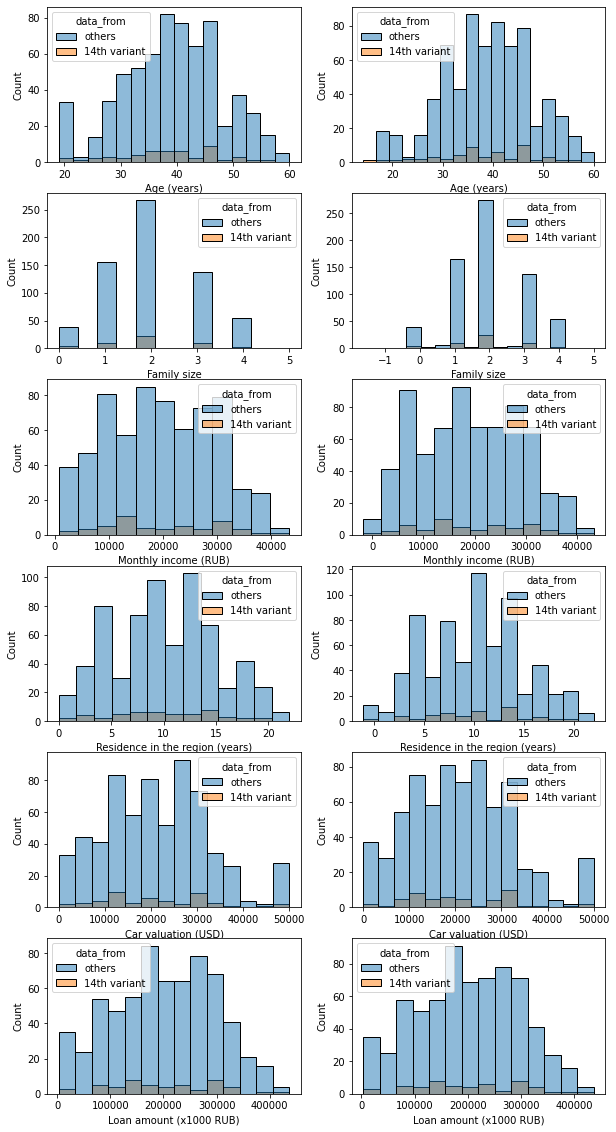

In [11]:
fig, axs = plt.subplots(6, 2)
fig.set_size_inches(10,20)

for i in range(6):
    sns.histplot(data=df, x=columns[i], ax=np.ravel(axs)[2*i], hue="data_from")
    sns.histplot(data=df_wo_missing, x=columns[i], ax=np.ravel(axs)[2*i + 1], hue="data_from")

Важное замечание: после работы EM-алгоритма (из-за его случайной природы) в данных появились явные ошибки.  
Например, все значения в данных по своей сущности не могут быть $<0$. Зададим минимальные значения данным, как в исходных.  
Снова посмотрим на аналогичные гистограммы:

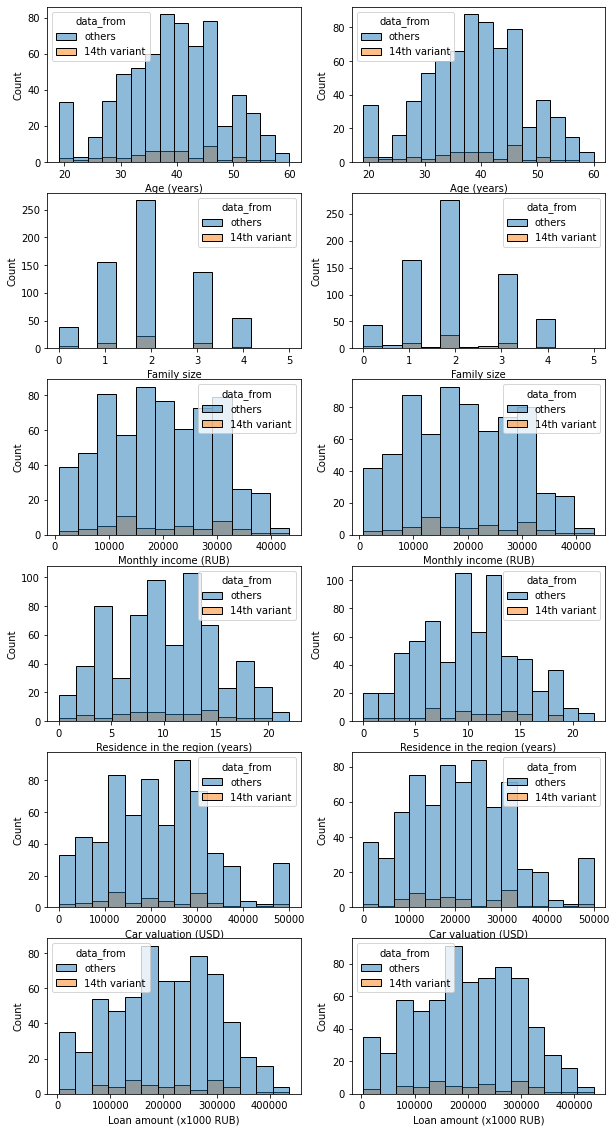

In [12]:
df_wo_missing.loc[:,:"Loan amount (x1000 RUB)"] = df_wo_missing.loc[:,:"Loan amount (x1000 RUB)"].clip(lower=df.min()[:-1], axis=1)

fig, axs = plt.subplots(6, 2)
fig.set_size_inches(10,20)

for i in range(6):
    sns.histplot(data=df, x=columns[i], ax=np.ravel(axs)[2*i], hue="data_from")
    sns.histplot(data=df_wo_missing, x=columns[i], ax=np.ravel(axs)[2*i + 1], hue="data_from")

### **3. Работа с выбросами**

Для работы с выбросами не будем сильно углубляться (ввиду малого объема исходных данных) и возьмём простую модель, основанную на методе ближайших соседей.  
Найдём точки, максимально удалённые от 4-х своих ближайших соседей:

In [13]:
df = df_wo_missing

from sklearn.neighbors import LocalOutlierFactor

model = LocalOutlierFactor(n_neighbors=4)
model.fit_predict(df.loc[:, :"Loan amount (x1000 RUB)"])
-np.sort(model.negative_outlier_factor_)[:25]

array([1.32941737e+14, 5.78611574e+13, 4.14247957e+13, 2.10024660e+13,
       1.80927878e+13, 1.50000433e+13, 1.34539585e+13, 1.05493325e+13,
       1.02757105e+13, 8.20204703e+12, 8.20203873e+12, 2.65636158e+12,
       1.00020447e+12, 1.00013843e+12, 1.00013581e+12, 1.95600608e+09,
       8.62451883e+03, 4.85957859e+03, 1.91834202e+03, 9.71176736e+02,
       1.64174657e+02, 1.64174657e+02, 1.64174657e+02, 1.17556801e+02,
       1.08449787e+02])

Число 4 выбрано так, чтобы получить не слишком много и не слишком мало выбросов:  
С таким параметром заметно далеко от своих соседей ($>10^3$) находятся 16 точек ($16/744 \approx 2.2\% $). Посчитаем, что это выбросы.

In [14]:
df = df.loc[-model.negative_outlier_factor_ < 1e4].reset_index(drop=True)
df14 = df.loc[df["data_from"] == "14th variant", :"Loan amount (x1000 RUB)"].reset_index(drop=True)
df

,Age (years),Family size,Monthly income (RUB),Residence in the region (years),Car valuation (USD),Loan amount (x1000 RUB),data_from
0,38.0,2.0,22600.0,8.0,22000.0,159093.802091,others
1,47.0,2.0,11200.0,14.0,12000.0,119000.0,others
2,58.385822,2.0,22500.0,9.0,22000.0,224000.0,others
3,51.0,3.0,16000.0,17.0,18000.0,173000.0,others
4,41.0,2.0,5358.740331,11.0,6000.0,57000.0,others
...,...,...,...,...,...,...,...
723,21.0,3.0,8200.0,11.0,48000.0,250000.0,others
724,40.0,2.0,12900.0,10.0,13000.0,127000.0,others
725,51.0,3.0,7100.0,17.0,9000.0,188782.998592,others
726,44.0,1.215222,16000.0,13.0,17000.0,165000.0,others


## Снижение размерности. Метод PCA. 
### **4. Центрирование и нормализация**
С помощью известного в кругах исследователей инструмента выполним стандартизацию данных  
(избавимся от среднего и приведём стандартное отклонение к 1)

In [15]:
from sklearn.preprocessing import StandardScaler

z = StandardScaler().fit_transform(df.loc[:, :"Loan amount (x1000 RUB)"])
z14 = StandardScaler().fit_transform(df14)
print(f"Проверка центрирования (must be equal to 0):\n{z.mean(axis=0)}\n{z14.mean(axis=0)}")
print(f"\nПроверка нормализации (must be equal to 1):\n{z.std(axis=0)}\n{z14.std(axis=0)}")

Проверка центрирования (must be equal to 0):
[ 1.85443846e-16 -2.41565010e-16 -9.15018976e-18  3.05006325e-17
  6.40513283e-17 -1.90933960e-16]
[-2.26670534e-16 -2.77555756e-17  2.12792746e-16 -2.59052039e-16
 -5.08852220e-17  1.29526020e-16]

Проверка нормализации (must be equal to 1):
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]


### **5. PCA**
Воспользуемся реализацией SVD-разложения в библиотеке numpy

In [16]:
u, s, vt = np.linalg.svd(z, full_matrices=False)
print(f"Сингулярные числа исходной матрицы:\n{s}")

u14, s14, v14t = np.linalg.svd(z14, full_matrices=False)
print(f"\nСингулярные числа исходной матрицы (вариант 14):\n{s14}")

Сингулярные числа исходной матрицы:
[43.75048278 41.69563235 21.08840471 10.51040235  9.07835054  8.81837174]

Сингулярные числа исходной матрицы (вариант 14):
[11.78076002 10.08932592  5.48901192  2.73999856  2.62098038  1.70669675]


Проверим, что произведение матриц даёт исходную (с погрешностью $10^{-8}$):

In [17]:
z_new = u @ np.diag(s) @ vt
np.allclose(z, z_new, atol=1e-8)

True

In [18]:
z_new = u14 @ np.diag(s14) @ v14t
np.allclose(z14, z_new, atol=1e-8)

True

Всё верно!
### **6. Исследование скрытых факторов**
Рассчитаем погрешности аппроксимации разным количеством признаков:

In [19]:
tmp_s = np.append(s, 0)
tmp_s_sq = tmp_s**2
print(f"Сингулярные числа исходной матрицы:\n{tmp_s[:-1].round(4)}")
print(f"Абсолютная погрешность аппроксимации в спектральной матричной норме:\n{tmp_s[1:].round(4)}")
abs_errors_f = tmp_s_sq[::-1].cumsum()[::-1][1:]
print(f"Абсолютная погрешность аппроксимации в норме Фробениуса:\n{abs_errors_f.round(4)}")
print(f"Относительная погрешность аппроксимации в норме Фробениуса, %:\n{(abs_errors_f/tmp_s_sq.sum()*100).round(4)}")

tmp_s = np.append(s14, 0)
tmp_s_sq = tmp_s**2
print(f"\nСингулярные числа исходной матрицы (вариант 14):\n{tmp_s[:-1].round(4)}")
print(f"Абсолютная погрешность аппроксимации в спектральной матричной норме (вариант 14):\n{tmp_s[1:].round(4)}")
abs_errors_f = tmp_s_sq[::-1].cumsum()[::-1][1:]
print(f"Абсолютная погрешность аппроксимации в норме Фробениуса (вариант 14):\n{abs_errors_f.round(4)}")
print(f"Относительная погрешность аппроксимации в норме Фробениуса, % (вариант 14):\n{(abs_errors_f/tmp_s_sq.sum()*100).round(4)}")

Сингулярные числа исходной матрицы:
[43.7505 41.6956 21.0884 10.5104  9.0784  8.8184]
Абсолютная погрешность аппроксимации в спектральной матричной норме:
[41.6956 21.0884 10.5104  9.0784  8.8184  0.    ]
Абсолютная погрешность аппроксимации в норме Фробениуса:
[2453.8953  715.3695  270.6487  160.1801   77.7637    0.    ]
Относительная погрешность аппроксимации в норме Фробениуса, %:
[56.1789 16.3775  6.1962  3.6671  1.7803  0.    ]

Сингулярные числа исходной матрицы (вариант 14):
[11.7808 10.0893  5.489   2.74    2.621   1.7067]
Абсолютная погрешность аппроксимации в спектральной матричной норме (вариант 14):
[10.0893  5.489   2.74    2.621   1.7067  0.    ]
Абсолютная погрешность аппроксимации в норме Фробениуса (вариант 14):
[149.2137  47.4192  17.2899   9.7824   2.9128   0.    ]
Относительная погрешность аппроксимации в норме Фробениуса, % (вариант 14):
[51.8103 16.465   6.0035  3.3966  1.0114  0.    ]


Заметим, что в обоих вариантах есть как минимум 2 важных скрытых фактора.  
При этом третий фактор тоже довольно важен (~10%).  
### **7. Представление клиентов векторами меньшей размерности**
Для аппроксимации возьмём 2 наиболее важных скрытых признака.  
Продублируем информацию о погрешностях: 

In [20]:
n_new_features = 2

tmp_s = np.append(s, 0)
tmp_s_sq = tmp_s**2
print(f"Абсолютная погрешность аппроксимации в спектральной матричной норме:\n{tmp_s[n_new_features].round(5)}")
abs_error_f = tmp_s_sq[::-1].cumsum()[::-1][n_new_features]
print(f"Абсолютная погрешность аппроксимации в норме Фробениуса:\n{abs_error_f.round(5)}")
print(f"Относительная погрешность аппроксимации в норме Фробениуса, %:\n{(abs_error_f/tmp_s_sq.sum()*100).round(5)}")

tmp_s = np.append(s14, 0)
tmp_s_sq = tmp_s**2
print(f"\nАбсолютная погрешность аппроксимации в спектральной матричной норме (вариант 14):\n{tmp_s[n_new_features].round(5)}")
abs_error_f = tmp_s_sq[::-1].cumsum()[::-1][n_new_features]
print(f"Абсолютная погрешность аппроксимации в норме Фробениуса (вариант 14):\n{abs_error_f.round(5)}")
print(f"Относительная погрешность аппроксимации в норме Фробениуса, % (вариант 14):\n{(abs_error_f/tmp_s_sq.sum()*100).round(5)}")

Абсолютная погрешность аппроксимации в спектральной матричной норме:
21.0884
Абсолютная погрешность аппроксимации в норме Фробениуса:
715.3695
Относительная погрешность аппроксимации в норме Фробениуса, %:
16.37751

Абсолютная погрешность аппроксимации в спектральной матричной норме (вариант 14):
5.48901
Абсолютная погрешность аппроксимации в норме Фробениуса (вариант 14):
47.4192
Относительная погрешность аппроксимации в норме Фробениуса, % (вариант 14):
16.465


Рассмотрим карту клиентов (вариант 14):

In [21]:
clients_approx = u[:,:n_new_features]
clients14_approx = u14[:,:n_new_features]
print(clients_approx.shape)
print(clients14_approx.shape)
clients14_approx.round(2)

(728, 2)
(48, 2)


array([[-0.14,  0.02],
       [ 0.2 , -0.33],
       [-0.07, -0.05],
       [-0.12, -0.16],
       [ 0.2 ,  0.04],
       [ 0.12,  0.22],
       [-0.2 ,  0.  ],
       [ 0.09, -0.12],
       [ 0.06,  0.05],
       [-0.  ,  0.14],
       [ 0.12, -0.02],
       [-0.11,  0.04],
       [-0.04, -0.09],
       [-0.2 , -0.14],
       [ 0.13,  0.03],
       [-0.23, -0.17],
       [-0.01,  0.02],
       [-0.05,  0.18],
       [-0.05,  0.2 ],
       [ 0.22,  0.16],
       [ 0.15, -0.37],
       [ 0.16,  0.14],
       [ 0.09,  0.  ],
       [ 0.15, -0.17],
       [-0.01, -0.02],
       [-0.19, -0.12],
       [ 0.09, -0.03],
       [ 0.13,  0.05],
       [ 0.09,  0.05],
       [-0.27,  0.02],
       [-0.16, -0.  ],
       [-0.3 ,  0.27],
       [ 0.14,  0.02],
       [ 0.18, -0.11],
       [ 0.03, -0.22],
       [ 0.13,  0.17],
       [ 0.01,  0.35],
       [ 0.1 ,  0.18],
       [-0.15, -0.  ],
       [-0.14, -0.28],
       [-0.17,  0.03],
       [-0.18,  0.03],
       [ 0.1 ,  0.06],
       [-0.

Для простоты и понятности визуального восприятия чисел, переведём данные в отрезок $[0; 10]$

In [22]:
from sklearn.preprocessing import MinMaxScaler

clients_approx = MinMaxScaler(feature_range=(0, 10)).fit_transform(clients_approx)
clients14_approx = MinMaxScaler(feature_range=(0, 10)).fit_transform(clients14_approx)
clients14_approx.round(2)

array([[ 2.96,  5.41],
       [ 9.56,  0.59],
       [ 4.29,  4.48],
       [ 3.45,  2.91],
       [ 9.48,  5.67],
       [ 8.06,  8.11],
       [ 1.83,  5.16],
       [ 7.47,  3.49],
       [ 6.81,  5.88],
       [ 5.64,  7.1 ],
       [ 8.01,  4.92],
       [ 3.61,  5.65],
       [ 4.86,  3.88],
       [ 1.89,  3.21],
       [ 8.22,  5.53],
       [ 1.33,  2.77],
       [ 5.55,  5.4 ],
       [ 4.66,  7.61],
       [ 4.76,  7.86],
       [10.  ,  7.37],
       [ 8.68,  0.  ],
       [ 8.87,  7.11],
       [ 7.51,  5.15],
       [ 8.6 ,  2.81],
       [ 5.44,  4.84],
       [ 2.07,  3.49],
       [ 7.52,  4.73],
       [ 8.14,  5.83],
       [ 7.45,  5.81],
       [ 0.57,  5.45],
       [ 2.64,  5.09],
       [ 0.  ,  8.9 ],
       [ 8.33,  5.42],
       [ 9.12,  3.58],
       [ 6.24,  2.09],
       [ 8.17,  7.41],
       [ 5.98, 10.  ],
       [ 7.65,  7.56],
       [ 2.87,  5.1 ],
       [ 2.99,  1.27],
       [ 2.38,  5.5 ],
       [ 2.17,  5.57],
       [ 7.7 ,  5.95],
       [ 3.

Графическое представление данных:

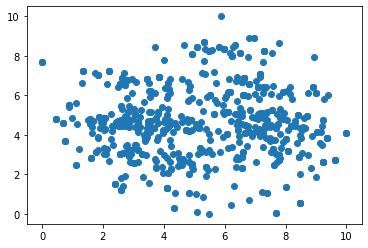

In [23]:
plt.scatter(x=clients_approx[:,0], y=clients_approx[:,1])

Вариант 14:

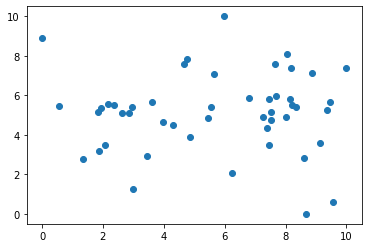

In [24]:
plt.scatter(x=clients14_approx[:,0], y=clients14_approx[:,1])

На обеих картинках четко видим 2 кластера: слева и справа.  
На нижней картинке сложнее определить границы и количество кластеров.  
Данные не очень-то хорошо укладываются в двумерное представление

## Снижение размерности. Интерпретация скрытых факторов.
### **8. Матрицы коэффициентов разложения признаков**

Рассмотрим, что описывают наши скрытые признаки. Построим матрицы корелляции, по вертикали новые признаки, по горизонтали - старые:

#### **Не могу понять, почему в матрицах числа большие 1.**
#### **Возможно, где-то в расчетах допущена ошибка, хотя SVD разложение выполнено верно.**
#### **Возможно, этой матрице просто нужна нормировка**

In [25]:
(np.diag(s[:n_new_features]) @ vt[:n_new_features]).round(5)

array([[ 12.16374,   0.68541, -22.63158,  13.81004, -22.10799, -23.95849],
       [ 20.73319,  25.30701,   7.09665,  21.49496,   7.74745,   9.78759]])

Вариант 14:

In [26]:
(np.diag(s14[:n_new_features]) @ v14t[:n_new_features]).round(5)

array([[ 3.14886, -0.14499, -6.07455,  4.1145 , -5.8832 , -6.35679],
       [ 4.5916 ,  6.57497,  1.89699,  5.13942,  2.24127,  1.564  ]])

**Тем не менее**, если трактовать эти матрицы, как матрицы зависимости признаков, где бОльшее по модулю значение означает бОльшую зависимость, то **можно явно заметить**, что: 
- Для матрицы из **объединения вариантов**:
  - **Первый** скрытый признак наиболее связан **с признаками 1, 3, 5 и 6**
  - **Второй** скрытый признак - **с признаками 2 и 4**
- Для матрицы из **варианта 14**:
  - **Первый** скрытый признак наиболее связан **с признаками 1, 3 и 4**
  - **Второй** скрытый признак - **с признаками 2, 5 и 6**

Такое расхождение попытаюсь объяснить
1. Возможно, неверной реализацией алгоритма ЕМ.  
   - Использованный фреймворк разработан неизвестными энтузиастами и не имеет широкого распространения в исследовательском сообществе
   - Он работает для каждой колонки по отдельности, а, возможно, должен пытаться "подогнать" общее распределение под нормальное
2. Возможно, случайной природой данных из разных вариантов работ  
   - Возможно, данные сгенерированы с разными параметрами для каждого варианта и их объединение не имеет смысла  
   - Оно имело бы смысл, когда число вариантов станет очень большим, по Центральной Предельной Теореме

### **9. Попытка словесной интерпретации скрытых признаков**
Выпишем ещё раз названия оригинальных признаков:

In [27]:
for i, col in enumerate(columns):
    print(f"Признак #{i+1} означает {col}")

Признак #1 означает Age (years)
Признак #2 означает Family size
Признак #3 означает Monthly income (RUB)
Признак #4 означает Residence in the region (years)
Признак #5 означает Car valuation (USD)
Признак #6 означает Loan amount (x1000 RUB)


## Снижение размерности. Метод MDS.
### **10. Зададим расстояния между клиентами**
Заметим, что все признаки в наших данных - численные.  
Это означает, что простое Евклидово расстояние между векторами клиентов может служить дистанцией.  
Возьмём уже знакомую нам стандартизированную матрицу $Z$:

In [28]:
print(z.shape)
print(z14.shape)
z.round(4)

(728, 6)
(48, 6)


array([[-0.1005,  0.004 ,  0.3369, -0.4285,  0.0893, -0.4581],
       [ 0.9241,  0.004 , -0.8348,  0.8223, -0.807 , -0.877 ],
       [ 2.2202,  0.004 ,  0.3266, -0.22  ,  0.0893,  0.22  ],
       ...,
       [ 1.3794,  0.9936, -1.2563,  1.4478, -1.0758, -0.148 ],
       [ 0.5825, -0.7725, -0.3415,  0.6139, -0.3588, -0.3964],
       [ 1.1517,  0.9936, -0.4545,  1.2393, -0.3588, -0.4591]])

### **11. Можно ли поместить клиентов в Евклидово пространство размерности 2 без потерь?**

Ответ - **нет, нельзя**. **Иначе** SVD разложение содержало бы только 2 сингулярных числа и абсолютная **погрешность** метода PCA с двумя скрытыми признаками **составляла бы ровно 0**.

### **12. MDS**

Воспользуемся реализацией Multidimensional Scaling из известного пакета scikit-learn:

In [29]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, metric=True, n_jobs=32, random_state=random_state, max_iter=1)
z_scaled = mds.fit_transform(z)
stress_on_start = mds.stress_
print(f"Начальное значение stress (1 итерация): {stress_on_start}")
mds = MDS(n_components=2, metric=True, n_jobs=32, random_state=random_state)
z_scaled = mds.fit_transform(z)
print(f"Финальное значение stress {mds.stress_}")
print(f"Относительная погрешность размещения: {mds.stress_/stress_on_start*100:.2f}%")
print(z_scaled.shape)

mds = MDS(n_components=2, metric=True, n_jobs=32, random_state=random_state, max_iter=1)
z14_scaled = mds.fit_transform(z14)
stress_on_start = mds.stress_
print(f"\nНачальное значение stress (1 итерация, вариант 14): {stress_on_start}")
mds = MDS(n_components=2, metric=True, n_jobs=32, random_state=random_state)
z14_scaled = mds.fit_transform(z14)
print(f"Финальное значение stress (вариант 14) {mds.stress_}")
print(f"Относительная погрешность размещения (вариант 14): {mds.stress_/stress_on_start*100:.2f}%")
print(z14_scaled.shape)

# Перевод в шкалу [0; 10]
z_scaled = MinMaxScaler(feature_range=(0, 10)).fit_transform(z_scaled)
z14_scaled = MinMaxScaler(feature_range=(0, 10)).fit_transform(z14_scaled)

Начальное значение stress (1 итерация): 2388392.6887262007
Финальное значение stress 50720.45141801918
Относительная погрешность размещения: 2.12%
(728, 2)

Начальное значение stress (1 итерация, вариант 14): 10408.618606687467
Финальное значение stress (вариант 14) 202.31766912757936
Относительная погрешность размещения (вариант 14): 1.94%
(48, 2)


Получили карты клиентов. Относительную погрешность можем приблизительно найти, поделив финальное значение stress на начальное.  
2 процента - отличное значение.  
Сравним с карты клиентов из MDS картами, полученными PCA:

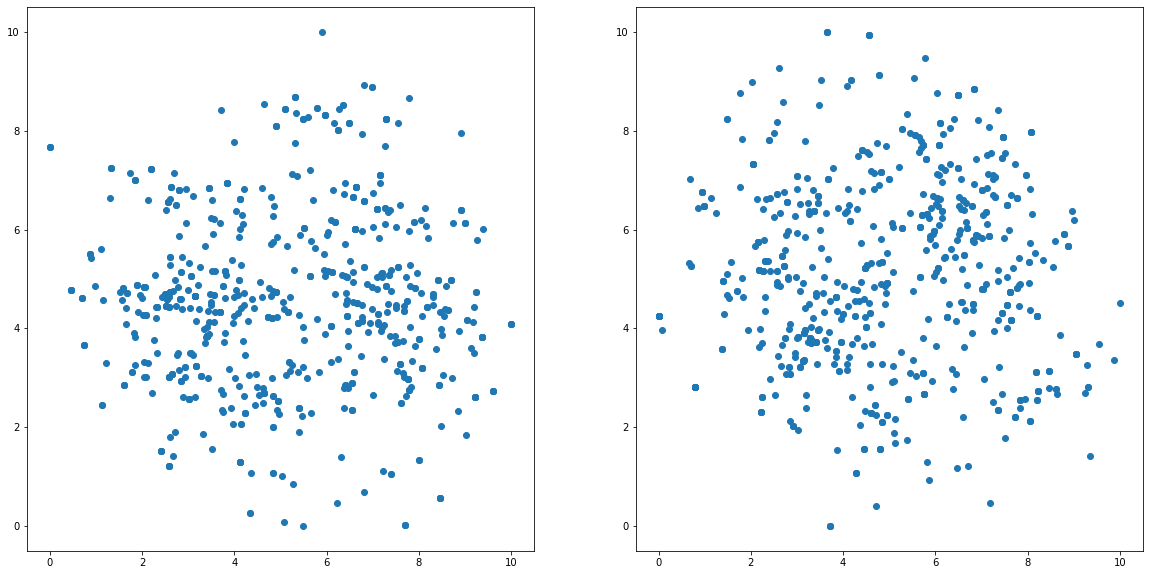

In [30]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20,10)

axs[0].scatter(x=clients_approx[:,0], y=clients_approx[:,1])
axs[1].scatter(x=z_scaled[:,1], y=z_scaled[:,0])

Вариант 14:

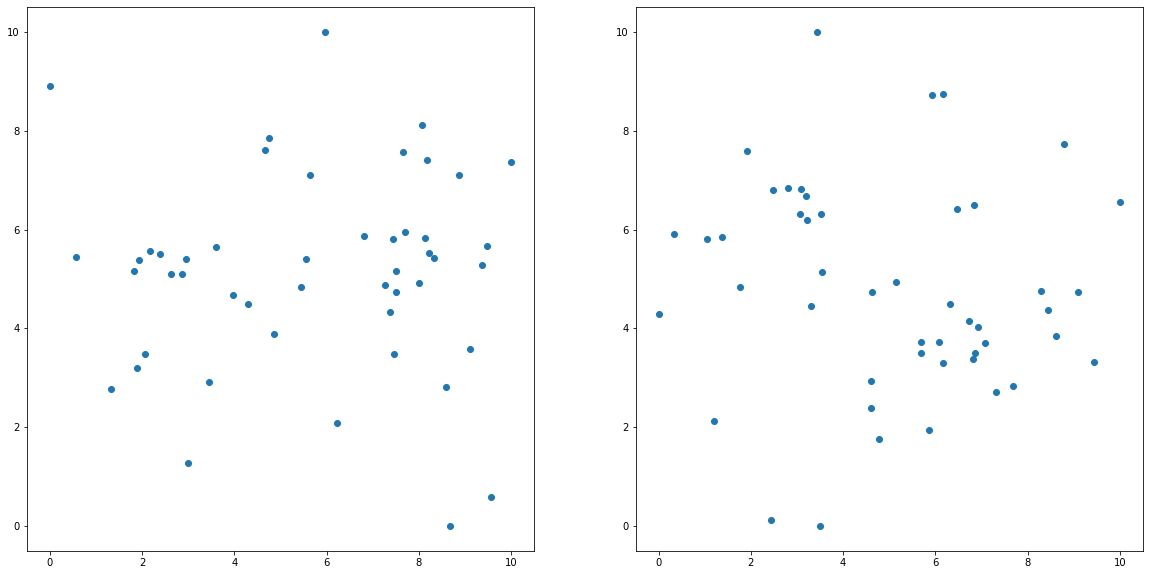

In [31]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20,10)

axs[0].scatter(x=clients14_approx[:,0], y=clients14_approx[:,1])
axs[1].scatter(x=z14_scaled[:,1], y=z14_scaled[:,0])

Наблюдаем очень интересную картину: данные из варианта 14 **после работы MDS** на плоскости выглядят **практически так же, как и после PCA**, за исключением поворота!  
(левую картинку необходимо **повернуть** по часовой стрелке примерно **на 45 градусов**; отдельно отмечу, что после MDS я **поменял местами скрытые признаки**)

Для картинок по общим данным **схожесть** не так очевидна, но всё же **прослеживается**!  
**Необходим** примерно такой же **поворот**

### Выводы:
1. Получилось на примере сравнить два метода понижения размерности данных: PCA и MDS
2. Оба метода интересны для использования и дают непротиворечивые результаты